In [1]:
from typing import Set, Dict, List

from numpy import mean, var, array, arange, repeat
from numpy import ndarray as Array
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style()

# Advantage and Disadvantage
When you have advantage, you roll two d20 and choose the highest. Disadvantage is same, but you choose the lowest.
Let's write some code and calculate expectation and deviation:

In [2]:
# rolls[name] are actual rolls of a {name} method, i.e. a number on dice to be used
rolls: Dict[str, Array] = {}

# It is not very different from outcomes[name], but this separation will come in handy later
outcomes: Dict[str, Array] = {}

In [3]:
# It's very easy to calculate roll results for both advantage and disadvantage
rolls['advantage']    = array([max(x, y) for x in range(1, 21) for y in range(1, 21)])
rolls['disadvantage'] = array([min(x, y) for x in range(1, 21) for y in range(1, 21)])

# Outcomes for this methods are the same as their rolls
for method in ('advantage', 'disadvantage'):
    outcomes[method] = rolls[method]

In [4]:
print(f'''
Advantage expectation:    {outcomes['advantage'].mean()}
Disadvantage expectation: {outcomes['disadvantage'].mean()}

Advantage deviation:      {outcomes['advantage'].var()}
Disadvantage deviation:   {outcomes['disadvantage'].var()}
''')


Advantage expectation:    13.825
Disadvantage expectation: 7.175

Advantage deviation:      22.194375
Disadvantage deviation:   22.194375



As it can be seen, advantage adds $3.325$ to the mean and disadvantage subtracts the same value, while both of their deviations are lowered by somewhat around $11$, which means improved consistency of throws (if you don't know to what values I'm talking, be sure to check the [Math](./Math.ipynb) section).

# Ability checks and saving throws: Alas, poor advantage!
## Advantage versus +3 bonus: fight!
As we have just seen, advantage must be strictly better than a +$3$ bonus, because it's more consistent (bare bonus has same deviation as usual roll, $33.25$) and it's mean value is higher than that of bare +$3$ bonus, which will be equal to $13.5$. But is it really *better* in all situations? Let's find out.

Here's the graphic that shows probability to succeed on a check while having either +$3$ bonus to it or an advantage.

In [5]:
# It's even easier to calculate roll results for +3 bonus,
# because it's just a flat roll
rolls['+3'] = arange(1, 21)

# And its outcome is increased by 3
outcomes['+3'] = rolls['+3'] + 3

In [6]:
# We consider all possible DCs from 0 to 25
DCs = arange(26)

# dc_pass[name] contains list of probabilities for the {name} method to succeed
# on the saving throw with DC corresponding to an index
dc_pass: Dict[str, Array] = {}

# This method calculates the dc_pass value for the specified method by simply
# checking whether each one of the outcomes would succeed and taking mean
# of resulting array of 0s and 1s, resulting in probability of success.
def calculate_dc_pass_for_method(method: str):
    dc_pass[method] = array([(outcomes[method] >= DC).mean() for DC in DCs])

In [7]:
calculate_dc_pass_for_method('advantage')
calculate_dc_pass_for_method('+3')

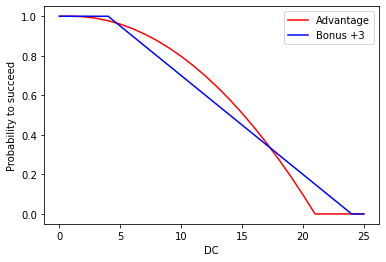

In [8]:
plt.plot(dc_pass['advantage'], 'r', label='Advantage')
plt.plot(dc_pass['+3'],        'b', label='Bonus +3')
plt.ylabel("Probability to succeed")
plt.xlabel("DC")
plt.legend()
plt.show()

Сounterintuitively, in *some* cases constant bonus is better than advantage. It can be seen that when Difficulty Class is bigger or equal to $18$, constant bonus is strictly better in terms of probability.

It happens because when rolling with advantage, but without any bonuses, you just *can't* get any value that exceeds $20$, but with bare bonus the result can be up to $23$, which results in bare bonus being better against high DC.

## New contenders: resistance & guidance!
Disclaimer: I will not write resistance & guidance every time. Instead, I will call it *residence*. No explanation provided.

Effect of the *residence* is quite simple: it adds d4 to the saving throw (resistance) or an ability check (guidance).

It seems that the *residence* spell is inferior to both +$3$ bonus and advantage, because it's mean is equal to $13$, and it's deviation is even bigger than deviation of usual roll - $34.5$ against $33.25$! But our intuition failed us once, so let's give *residence* a try.

In [9]:
# Residence rolls are just a bare rolls of d20, but for each one we need 4 copies
# (to make shape the same as outcomes)
rolls['residence'] = repeat(arange(1, 21), 4)

# But d4 is added to each outcome
outcomes['residence'] = array([bare + bonus for bonus in range(1, 5) for bare in range(1, 21)])

calculate_dc_pass_for_method('residence')

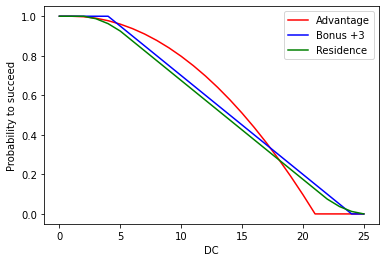

In [10]:
plt.plot(dc_pass['advantage'], 'r', label='Advantage')
plt.plot(dc_pass['+3'],        'b', label='Bonus +3')
plt.plot(dc_pass['residence'], 'g', label='Residence')
plt.ylabel("Probability to succeed")
plt.xlabel("DC")
plt.legend()
plt.show()

We were almost right, in **most** cases, *residence* is slightly inferior than +$3$ bonus, and it behaves in almost the same way - it overcomes advantage on some AC values. But if you're perceptive enough, you can see, that in the very end of the graphic *bless* overcomes +$3$ bonus. It happens, when DC is equal to $24$:

In [11]:
print(f'''
Chances to pass DC 23:
Residence: {dc_pass['residence'][24]}
Bonus +3:  {dc_pass['+3'][24]}
Advantage: {dc_pass['advantage'][24]}
''')


Chances to pass DC 23:
Residence: 0.0125
Bonus +3:  0.0
Advantage: 0.0



Why does this happen? Simply because +$3$ bonus can't pass $24$ DC, while *residence* can do this on crit and $4$ rolled on an additional dice.

# Attacks: from zero to hero!
Advantage may make poor impression when talking about ability checks and saving throws. But in terms of attacking it really shines. It happens mostly because of crit on the roll of $20$ and guaranteed miss on the roll of $1$. Let's put advantage back on it's pedestal!

First, let's compare **chances to hit** an enemy while having advantage and +$3$ bonus to the attack:

In [12]:
# Simple method to determine whether an attack with the specified
# roll(s) and outcome(s) hits the target with the specified AC
def hits(AC: int, roll: Array, outcome: Array) -> Array:
    return ((outcome >= AC) & (roll != 1)) | (roll == 20)

# We are considering all possible ACs from 0 to 25
ACs = arange(26)

# Almost the same thing as dc_pass:
# it holds the list of probabilities to hit for specified method
ac_hits: Dict[str, Array] = {}

# And, again, simple method to calculate it
def calculate_ac_hits_for_method(method: str):
    ac_hits[method] = array([hits(AC, rolls[method], outcomes[method]).mean() for AC in ACs])

In [13]:
calculate_ac_hits_for_method('advantage')
calculate_ac_hits_for_method('+3')

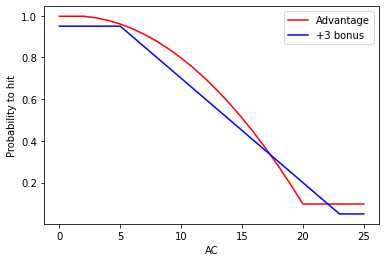

In [14]:
plt.plot(ac_hits['advantage'], 'r', label='Advantage')
plt.plot(ac_hits['+3'],        'b', label='+3 bonus')
plt.ylabel("Probability to hit")
plt.xlabel("AC")
plt.legend()
plt.show()

As it can be seen, now advantage is looking much better, but bare bonus still surpasses it on high values of AC, on the segment from $18$ to $23$ to be exact.

Talking about attacks, we must consider not only when attack hits or not, but also about damage of that attack. And, as you remember, we roll twice as many damage dice on a critical hit. Let us consider simple [club](https://roll20.net/compendium/dnd5e/Club#h-Club "Club") as our weapon, because even with it's small damage die, advantage will shine. Let's calculate it now!

**P.S.:** we would consider different weapons later on, as well as corresponding feats.

In [15]:
# Let us consider a character with 10 Strength, i.e. +0 modifier. 
# For such character, mean damage and mean crit damage of the club would be:
club_damage_mean = 2.5
club_damage_crit_mean = 5

In [16]:
# Method to calculate the damage (mean for club) from an attack with
# specified roll and outcome against specified AC
def damages(AC: int, roll: Array, outcome: Array) -> Array:
    return club_damage_mean * ((outcome >= AC) & (roll != 1) & (roll != 20)) + club_damage_crit_mean * (roll == 20) 
    
# Almost the same thing as ac_hits but now with damage attached to it:
# it holds the list of mean damage for specified method
ac_damages: Dict[str, Array] = {}

# And, again, a method to calculate it
def calculate_damages_for_method(method: str):
    ac_damages[method] = array([damages(AC, rolls[method], outcomes[method]).mean() for AC in ACs])

In [17]:
calculate_damages_for_method('advantage')
calculate_damages_for_method('+3')

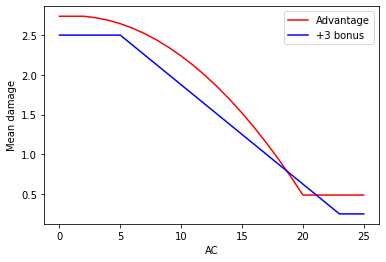

In [18]:
plt.plot(ac_damages['advantage'], 'r', label='Advantage')
plt.plot(ac_damages['+3'],        'b', label='+3 bonus')
plt.ylabel("Mean damage")
plt.xlabel("AC")
plt.legend()
plt.show()

Now advantage greatly overcomes bare bonus in most cases, except for AC values of $19$, $20$ and $21$:

In [19]:
for AC in (19, 20, 21):
    print(f'''
Mean damages for AC {AC}:
Bonus +3:  {ac_damages['+3'][AC]}
Advantage: {ac_damages['advantage'][AC]}
''')


Mean damages for AC 19:
Bonus +3:  0.75
Advantage: 0.71875


Mean damages for AC 20:
Bonus +3:  0.625
Advantage: 0.4875


Mean damages for AC 21:
Bonus +3:  0.5
Advantage: 0.4875



## New-old contender: bless.
*Bless* spell affects attack rolls in the same way as *residence* affects saving throws and ability checks: by adding a d4 to the result.

Let's include it in our competition for damage averages:

In [20]:
# Rolls and outcomes for bless are the same as for residence
rolls['bless'] = rolls['residence']
outcomes['bless'] = outcomes['residence']

In [21]:
calculate_damages_for_method('bless')

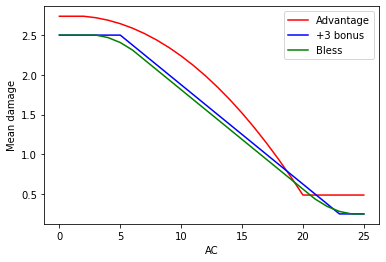

In [22]:
plt.plot(ac_damages['advantage'], 'r', label='Advantage')
plt.plot(ac_damages['+3'],        'b', label='+3 bonus')
plt.plot(ac_damages['bless'],     'g', label='Bless')
plt.ylabel("Mean damage")
plt.xlabel("AC")
plt.legend()
plt.show()

*Bless* overcomes advantage on AC of $20$ and bare +$3$ bonus on AC of $23$, but in other cases it's strictly inferior.

### Honorable mention: Elven Accuracy
This feat is incredible in my opinion. Let's calculate expectation and deviation of a roll that is affected by this *triple-advantage feat*.

In [23]:
rolls['elven'] = array([max(x, y, z) for x in range(1, 21) for y in range(1, 21) for z in range(1, 21)])
outcomes['elven'] = rolls['elven']

In [24]:
print(f'''
Advantage expectation:    {outcomes['elven'].mean()}
Advantage deviation:      {outcomes['elven'].var()}
''')


Advantage expectation:    15.4875
Advantage deviation:      14.95834375



This feat adds $4.9875$ to the expectation and reduces deviation by somewhat around $18$, which means **greatly** improved consistency.

Let's just check it's damage average compared to usual advantage and +$3$ bonus:

In [25]:
calculate_damages_for_method('elven')

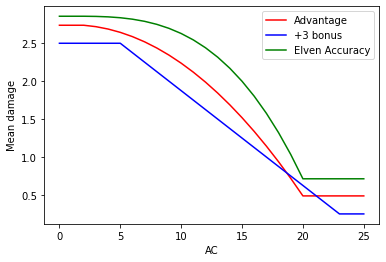

In [26]:
plt.plot(ac_damages['advantage'], 'r', label='Advantage')
plt.plot(ac_damages['+3'],        'b', label='+3 bonus')
plt.plot(ac_damages['elven'],     'g', label='Elven Accuracy')
plt.ylabel("Mean damage")
plt.xlabel("AC")
plt.legend()
plt.show()

As it can be easily seen, *elven accuracy* is far superior than any other type of bonus. We have a honorably mentioned winner!